# Fruit Price Prediction Using RNN-LSTM & ARIMA

 

In [35]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import mean_absolute_error

In [36]:
# Directory containing input files
DIR_IN = "/kaggle/input/agriculture-vegetables-fruits-time-series-prices/"
# Working directory (the only writable place in a Kaggle's work)
DIR_WORK = "/kaggle/working/"
# Full path to the input file
FILE_IN = os.path.join(DIR_IN, "kalimati_tarkari_dataset.csv")
# Name of the fruit of which the price will be predicted
PLACE = "NV"
# Date used to split the training and the test part
SPLIT_DATE = "2020-05-01"
# Size of the window applied to the time series
WINDOW_SIZE = 10
# Batch size for model training and prediction
BATCH_SIZE = 32
# Buffer size used to shuffle the training set, should be bigger than the dataset's size
SHUFFLE_BUFFER = 3000

In [37]:
df = pd.read_csv(FILE_IN, sep=",")
df

,SN,Commodity,Date,Unit,Minimum,Maximum,Average
0,0,Tomato Big(Nepali),2013-06-16,Kg,35.0,40.0,37.5
1,1,Tomato Small(Local),2013-06-16,Kg,26.0,32.0,29.0
2,2,Potato Red,2013-06-16,Kg,20.0,21.0,20.5
3,3,Potato White,2013-06-16,Kg,15.0,16.0,15.5
4,4,Onion Dry (Indian),2013-06-16,Kg,28.0,30.0,29.0
...,...,...,...,...,...,...,...
197156,197156,Garlic Dry Nepali,2021-05-13,Kg,100.0,120.0,110.0
197157,197157,Fish Fresh(Rahu),2021-05-13,KG,270.0,280.0,275.0
197158,197158,Fish Fresh(Bachuwa),2021-05-13,KG,225.0,235.0,230.0
197159,197159,Fish Fresh(Chhadi),2021-05-13,KG,220.0,230.0,225.0


In [38]:
pip install pandas geonamescache

Note: you may need to restart the kernel to use updated packages.


We consider only three columns:
- **Commodity**: used to filter the fruit type
- **Date**: used as the time series index
- **Average**: average price of the fruit

So let's filter the fruit type, in this work we predict the price of 'Potato Red' but you should feel free to test with other fruit types

In [39]:
import pandas as pd
import random
from geonamescache import GeonamesCache

# Set a fixed random seed for reproducibility
random.seed(42)  # You can change 42 to any fixed number to control the randomness

# Fetch a list of places using GeonamesCache
gc = GeonamesCache()
places = list(gc.get_us_states().keys())  # Using US states as an example

# Shuffle to randomize with the fixed seed
random.shuffle(places)

# Get unique crop names
unique_crops = df['Commodity'].unique()

# Check if we have enough place names
if len(unique_crops) > len(places):
    # If not enough places, repeat the place list to make it longer
    multiplier = (len(unique_crops) // len(places)) + 1
    places *= multiplier  # Extend the list by repeating it
    random.shuffle(places)  # Shuffle again for randomness with the fixed seed

# Create a mapping of crop names to place names
crop_to_place_mapping = {crop: places[i] for i, crop in enumerate(unique_crops)}

# Replace the crop names in the DataFrame
df['Commodity'] = df['Commodity'].map(crop_to_place_mapping)

# Output the DataFrame to check the replacements
df

,SN,Commodity,Date,Unit,Minimum,Maximum,Average
0,0,WA,2013-06-16,Kg,35.0,40.0,37.5
1,1,MD,2013-06-16,Kg,26.0,32.0,29.0
2,2,VA,2013-06-16,Kg,20.0,21.0,20.5
3,3,AZ,2013-06-16,Kg,15.0,16.0,15.5
4,4,AR,2013-06-16,Kg,28.0,30.0,29.0
...,...,...,...,...,...,...,...
197156,197156,LA,2021-05-13,Kg,100.0,120.0,110.0
197157,197157,MS,2021-05-13,KG,270.0,280.0,275.0
197158,197158,CO,2021-05-13,KG,225.0,235.0,230.0
197159,197159,MN,2021-05-13,KG,220.0,230.0,225.0


In [40]:
df.Commodity.value_counts()

Commodity
AZ    6716
NV    6635
AK    6620
IL    6493
MT    6476
NJ    6023
LA    5941
MS    5900
KS    5669
MN    5633
PA    5630
SC    5531
IN    5454
VA    5438
TN    5381
ME    5328
IA    5298
MI    4973
HI    4942
CA    4437
NC    4000
GA    3853
WI    3751
NM    3682
ND    3658
MD    3613
SD    3397
AR    3305
NH    3204
VT    3198
WA    3176
NE    3159
UT    3123
WV    3021
AL    2851
DE    2843
TX    2735
ID    2641
MO    2560
KY    2521
WY    2323
OR    2262
FL    2211
NY    2020
MA    1841
OK    1614
OH    1513
RI    1378
CO    1312
CT    1213
DC     665
Name: count, dtype: int64

In [41]:
df = df[df['Commodity'] == PLACE]
df

,SN,Commodity,Date,Unit,Minimum,Maximum,Average
6,6,NV,2013-06-16,Kg,6.0,10.0,8.0
41,41,NV,2013-06-16,Kg,120.0,130.0,125.0
80,80,NV,2013-06-17,Kg,6.0,10.0,8.0
114,114,NV,2013-06-17,Kg,120.0,130.0,125.0
153,153,NV,2013-06-18,Kg,8.0,10.0,9.0
...,...,...,...,...,...,...,...
196938,196938,NV,2021-05-11,Kg,50.0,60.0,55.0
196989,196989,NV,2021-05-12,Kg,20.0,25.0,22.5
197030,197030,NV,2021-05-12,Kg,50.0,60.0,55.0
197079,197079,NV,2021-05-13,Kg,20.0,25.0,22.5


In [42]:
df = df.groupby('Date', as_index=False)['Average'].mean()
df

,Date,Average
0,2013-06-16,66.50
1,2013-06-17,66.50
2,2013-06-18,67.00
3,2013-06-19,68.75
4,2013-06-20,68.75
...,...,...
2746,2021-05-09,35.00
2747,2021-05-10,40.00
2748,2021-05-11,38.75
2749,2021-05-12,38.75


In [43]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head()

,Average
Date,
2013-06-16,66.50
2013-06-17,66.50
2013-06-18,67.00
2013-06-19,68.75
2013-06-20,68.75


# Missing Value Handling

In [44]:
missing_values = df[df['Average'].isna()]
print(missing_values)

Empty DataFrame
Columns: [Average]
Index: []


**Imputation (Forward Fill)**

In [45]:
df = df.ffill()
print(f"After ffill, there is {len(df[df['Average'].isna()])} NaN value")

After ffill, there is 0 NaN value


In [46]:
def plot_series(x, y, start=0, end=None, title=None, xlabel=None, ylabel=None):
    """
    Utility function to plot a series
    
    Args:
        x (1d Numpy array): values for the x-axis
        y (tuple of Numpy arrays or 1d Numpy array): values for the y-axis
        start (int): start index
        end (int): end index
        title (str): title of the plot
        xlabel (str): label for the x-axis
        ylabel (str): label for the y-axis
    """
    # Set figure's size
    plt.figure(figsize=(10, 6))
    
    
    # If y is a tuple containing multiple sets of values then plot them all
    if type(y) is tuple:
        for val_set in y:
            plt.plot(x[start: end], val_set[start: end])
    else:
        plt.plot(x[start: end], y[start: end])

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)    
    plt.show()

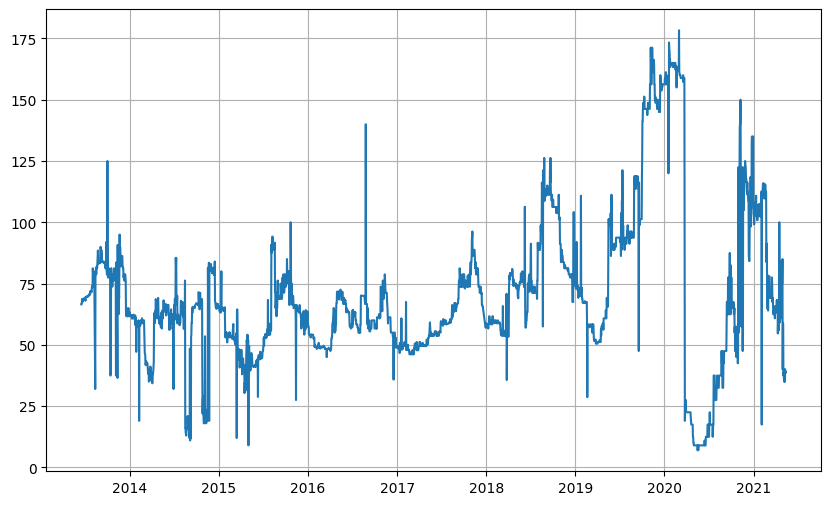

In [47]:
plot_series(df.index, df['Average'])

In [48]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [49]:
import pandas as pd
import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tsa.arima_model import ARMAResults,ARIMAResults
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tools.eval_measures import rmse
from statsmodels.graphics.tsaplots import month_plot,quarter_plot
from statsmodels.tsa.stattools import adfuller


from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
from dateutil.parser import parse
from scipy import stats
from scipy.stats import normaltest
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

In [50]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        
adf_test(df["Average"])

Augmented Dickey-Fuller Test: 
ADF test statistic        -3.687691
p-value                    0.004290
# lags used                5.000000
# observations          2745.000000
critical value (1%)       -3.432734
critical value (5%)       -2.862593
critical value (10%)      -2.567331
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


Augmented Dickey-Fuller Test: 
ADF test statistic     -1.343898e+01
p-value                 3.878936e-25
# lags used             1.900000e+01
# observations          2.730000e+03
critical value (1%)    -3.432748e+00
critical value (5%)    -2.862599e+00
critical value (10%)   -2.567334e+00
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary


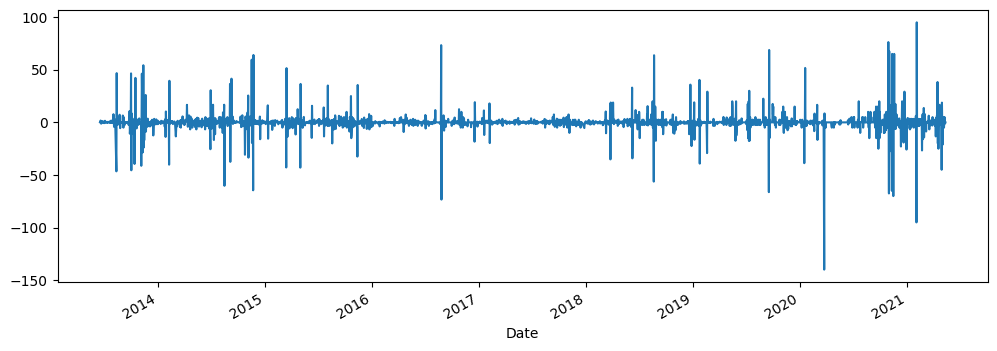

In [51]:
df["difference_1"]= diff(df["Average"], k_diff=1)
df["difference_1"].plot(figsize=(12,4))

adf_test(df["difference_1"])

In [52]:
df = df.dropna()
df_train = df[df.index < SPLIT_DATE]
df_test = df[df.index >= SPLIT_DATE]

Text(0.5, 1.0, 'Partial Autocorrelation Function')

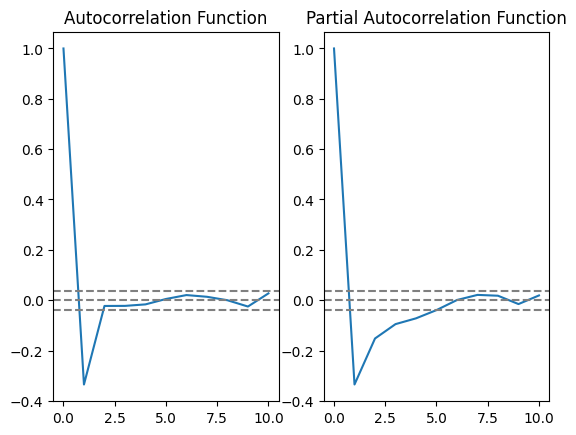

In [53]:
from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(df.difference_1,nlags=10)
lag_pacf = pacf(df.difference_1,nlags=10,method ='ols')

#ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df['difference_1'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df['difference_1'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df['difference_1'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df['difference_1'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')

/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/p

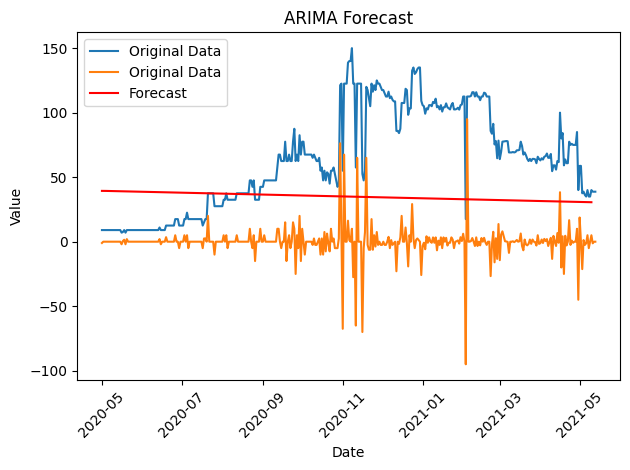

In [54]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Sample data: Replace with your time series data
# Assume data is monthly from 2013 onward
dates = df_train.index
data = df_train.difference_1
# Fit an ARIMA model
model = ARIMA(data, order=(1, 0, 1))
model_fit = model.fit()

# Forecast for the next 365 days (12 months with daily frequency)
forecast = model_fit.forecast(steps=375)
last_observed_value = df['Average'].iloc[-1]  # The last observed value in the original data
forecast_original_scale = forecast.cumsum() + last_observed_value


# Generate daily forecast dates
forecast_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=375, freq='D')

# Plot the original data
plt.plot(df_test.index, df_test, label='Original Data')

# Plot the forecasted data
plt.plot(forecast_dates, forecast_original_scale, label='Forecast', color='red')

# Add legend and labels
plt.legend()
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("ARIMA Forecast")

# Rotate date labels for better visibility
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of date labels
plt.show()

In [55]:
mae = mean_absolute_error(df_test.Average, forecast_original_scale).numpy()
mean = np.mean(df_test.Average)

print(f"MAE = {mae:.2f}")
print(f"MAE / mean = {(mae/mean * 100):.2f} %")

MAE = 40.35
MAE / mean = 63.80 %


# LSTM model

In [56]:
df = pd.read_csv(FILE_IN, sep=",")

In [57]:
pip install pandas geonamescache

Note: you may need to restart the kernel to use updated packages.


In [58]:
import pandas as pd
import random
from geonamescache import GeonamesCache

# Set a fixed random seed for reproducibility
random.seed(42)  # You can change 42 to any fixed number to control the randomness

# Fetch a list of places using GeonamesCache
gc = GeonamesCache()
places = list(gc.get_us_states().keys())  # Using US states as an example

# Shuffle to randomize with the fixed seed
random.shuffle(places)

# Get unique crop names
unique_crops = df['Commodity'].unique()

# Check if we have enough place names
if len(unique_crops) > len(places):
    # If not enough places, repeat the place list to make it longer
    multiplier = (len(unique_crops) // len(places)) + 1
    places *= multiplier  # Extend the list by repeating it
    random.shuffle(places)  # Shuffle again for randomness with the fixed seed

# Create a mapping of crop names to place names
crop_to_place_mapping = {crop: places[i] for i, crop in enumerate(unique_crops)}

# Replace the crop names in the DataFrame
df['Commodity'] = df['Commodity'].map(crop_to_place_mapping)

In [59]:
df = df[df['Commodity'] == PLACE]
df = df.groupby('Date', as_index=False)['Average'].mean()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df

,Average
Date,
2013-06-16,66.50
2013-06-17,66.50
2013-06-18,67.00
2013-06-19,68.75
2013-06-20,68.75
...,...
2021-05-09,35.00
2021-05-10,40.00
2021-05-11,38.75


In [60]:
df_train = df[df.index < SPLIT_DATE]
df_test = df[df.index >= SPLIT_DATE]

time_test = df_test.index  # just used for plotting results at the end

X_train = df_train['Average'].values  # convert to Numpy array
X_test = df_test['Average'].values  # convert to Numpy array

print(f"X_train shape = {X_train.shape}; X_test shape = {X_test.shape}")
print(f"Some X_train data: {X_train[:10]}")

X_train shape = (2376,); X_test shape = (375,)
Some X_train data: [66.5  66.5  67.   68.75 68.75 67.5  68.75 68.75 68.5  68.5 ]


In [61]:
def window_train(series, window_size, batch_size, shuffle_buffer):
    """
    Convert the train series to Tensorflow Dataset
    
    Args:
        series (1d Numpy array): input time series data
        window_size (int): size of the sliding window
        batch_size (int): number of elements in each batch
        shuffle_buffer (int): buffer size used for shuffling
        
    Returns:
        A Tensorflow Dataset where each batch's element is a tuple ([v-N, ..., v-1], [v])
        where v, v-1, ..., v-N are values at time t, t-1, ..., t-N, respectively.
    """
    # Convert the input series into Tensorflow Dataset
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Convert dataset into a new dataset containing windows where
    # each window is itself a dataset of size (window_size + 1).
    # Hey! Note that below we use (window_size + 1) because we want the last element
    # to be the prediction result (like labels in classification problems)
    dataset = dataset.window(window_size + 1, shift=1, stride=1, drop_remainder=True)
    
    # Flatten the new dataset by converting each of its window (sub-dataset) into
    # a single batch then join them together by using the flat_map function
    dataset = dataset.flat_map(lambda w: w.batch(window_size + 1))
    
    # Separate each batch into two parts: past values and present value
    dataset = dataset.map(lambda w: (w[:-1], w[-1]))
    
    # We should shuffle the training set to avoid that the sequenced
    # order of the input data impacts the trained model
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Group the single batches into bigger batches (to profit parallelism)
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

def window_test(series, window_size, batch_size):
    """
    Convert the test series to Tensorflow Dataset
    """
    dataset = tf.data.Dataset.from_tensor_slices(series)
    # Note that we need to use window_size instead of window_size + 1 as for
    # the training set because we're working on the test set
    dataset = dataset.window(window_size, shift=1, stride=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

# Create the train dataset
ds_train = window_train(X_train, WINDOW_SIZE, BATCH_SIZE, SHUFFLE_BUFFER)
# Create the test set.
# Note that we have to use the last WINDOW_SIZE elements of the training set
# to predict the first element of the test set, and we have to exclude the last element
# of the test set because it won't be used to predict the value at its next timestep
ds_test = window_test(np.concatenate((X_train[-WINDOW_SIZE:], X_test[:-1])), WINDOW_SIZE, BATCH_SIZE)

# Just checking shapes
for batch in ds_train.take(1):
    print(batch[0].shape)
    print(batch[1].shape)
print("--------------------")
for batch in ds_test.take(1):
    print(batch.shape)

(32, 10)
(32,)
--------------------
(32, 10)


Now it's time to build our prediction model using LSTM.<br>
Note that we can use Tensorflow's Lambda layer to save some processing steps. In this model, the first Lambda layer expands the input's dimension, this is because each batch input is a 2d array (\[batch_size, values\]) while LSTM layers (or RNN layers in general) need 3-dimension inputs (\[batch_size, timesteps, values\]).<br>
The last Lambda layer is just to scale up the outputs because the outputs of LSTM are normally in \[-1, 1\] as it uses tanh functions, whereas the real prices seem to be in (0, ~100), this allows speeding up the performance a little bit

In [62]:
# tf.keras.backend.clear_session()
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import *
# from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.losses import MeanSquaredError
# from tensorflow.keras.metrics import RootMeanSquaredError
# from tensorflow.keras.optimizers import Adam

# model = Sequential([
#     Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW_SIZE]),
#     Bidirectional(LSTM(32, return_sequences=True)),
#     Bidirectional(LSTM(32)),
#     Dense(1),
#     Lambda(lambda x: x * 100.0)
# ])
# init_weights = model.get_weights()

# model.summary()

In [63]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Clear any previous session
tf.keras.backend.clear_session()

# Define the model
model = Sequential([
    Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW_SIZE]),
    
    # First Conv1D layer
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    # Second Conv1D layer
    Conv1D(filters=64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    
    # LSTM layers
    Bidirectional(LSTM(32, return_sequences=True)),
    Bidirectional(LSTM(32)),
    
    # Dense and final output layers
    Dense(1),
    Lambda(lambda x: x * 100.0)
])

# Initialize weights
init_weights = model.get_weights()

# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 10, 1)             0         
                                                                 
 conv1d (Conv1D)             (None, 8, 64)             256       
                                                                 
 max_pooling1d (MaxPooling1  (None, 4, 64)             0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 64)             12352     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 bidirectional (Bidirection  (None, 1, 64)             2

In [64]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Lambda, Bidirectional, Dropout
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# model = Sequential([
#     Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[WINDOW_SIZE]),
#     Bidirectional(LSTM(64, return_sequences=True, dropout=0.2)),
#     Bidirectional(LSTM(64, dropout=0.2)),
#     Dense(1),
#     Lambda(lambda x: x * 100.0)
# ])

In [65]:
lr_schd = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

model.compile(loss=Huber(), optimizer=Adam())

hist = model.fit(ds_train, epochs=100, callbacks=[lr_schd])

Epoch 1/100


I0000 00:00:1725542568.871060     118 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


74/74 [==============================] - 12s 11ms/step - loss: 73.1733 - lr: 1.0000e-08
Epoch 2/100
74/74 [==============================] - 1s 8ms/step - loss: 73.1547 - lr: 1.1220e-08
Epoch 3/100
74/74 [==============================] - 1s 9ms/step - loss: 73.1329 - lr: 1.2589e-08
Epoch 4/100
74/74 [==============================] - 1s 8ms/step - loss: 73.1086 - lr: 1.4125e-08
Epoch 5/100
74/74 [==============================] - 1s 10ms/step - loss: 73.0829 - lr: 1.5849e-08
Epoch 6/100
74/74 [==============================] - 1s 9ms/step - loss: 73.0557 - lr: 1.7783e-08
Epoch 7/100
74/74 [==============================] - 1s 9ms/step - loss: 73.0242 - lr: 1.9953e-08
Epoch 8/100
74/74 [==============================] - 1s 8ms/step - loss: 72.9872 - lr: 2.2387e-08
Epoch 9/100
74/74 [==============================] - 1s 9ms/step - loss: 72.9461 - lr: 2.5119e-08
Epoch 10/100
74/74 [==============================] - 1s 9ms/step - loss: 72.8990 - lr: 2.8184e-08
Epoch 11/100
74/74 [========

(1e-08, 0.001, 0.0, 100.0)

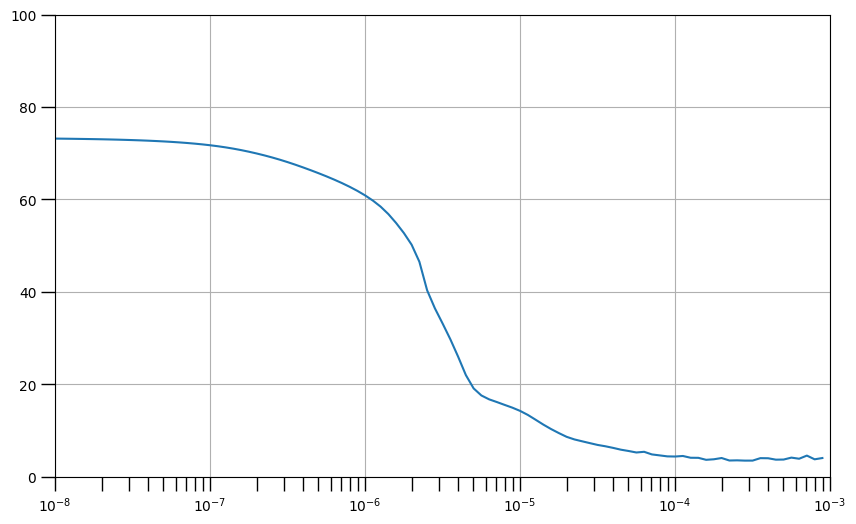

In [66]:
lr_arr = 1e-8 * (10 ** (np.arange(100) / 20))

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.semilogx(lr_arr, hist.history['loss'])
plt.tick_params('both', length=10, width=1, which='both')
plt.axis([1e-8, 1e-3, 0, 100])

In [67]:
model.set_weights(init_weights)

model.compile(loss=Huber(), optimizer=Adam(learning_rate=2*1e-4), metrics=['mae'])
# Callbacks for training
#early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



hist = model.fit(ds_train, epochs=200)

Epoch 1/200
74/74 [==============================] - 8s 9ms/step - loss: 24.6655 - mae: 25.1563
Epoch 2/200
74/74 [==============================] - 1s 9ms/step - loss: 9.5015 - mae: 9.9810
Epoch 3/200
74/74 [==============================] - 1s 9ms/step - loss: 7.1044 - mae: 7.5766
Epoch 4/200
74/74 [==============================] - 1s 9ms/step - loss: 5.8246 - mae: 6.2887
Epoch 5/200
74/74 [==============================] - 1s 9ms/step - loss: 4.9737 - mae: 5.4288
Epoch 6/200
74/74 [==============================] - 1s 9ms/step - loss: 4.4831 - mae: 4.9369
Epoch 7/200
74/74 [==============================] - 1s 9ms/step - loss: 4.6017 - mae: 5.0657
Epoch 8/200
74/74 [==============================] - 1s 10ms/step - loss: 3.7353 - mae: 4.1885
Epoch 9/200
74/74 [==============================] - 1s 9ms/step - loss: 3.8722 - mae: 4.3300
Epoch 10/200
74/74 [==============================] - 1s 9ms/step - loss: 3.4893 - mae: 3.9416
Epoch 11/200
74/74 [==============================] - 1s

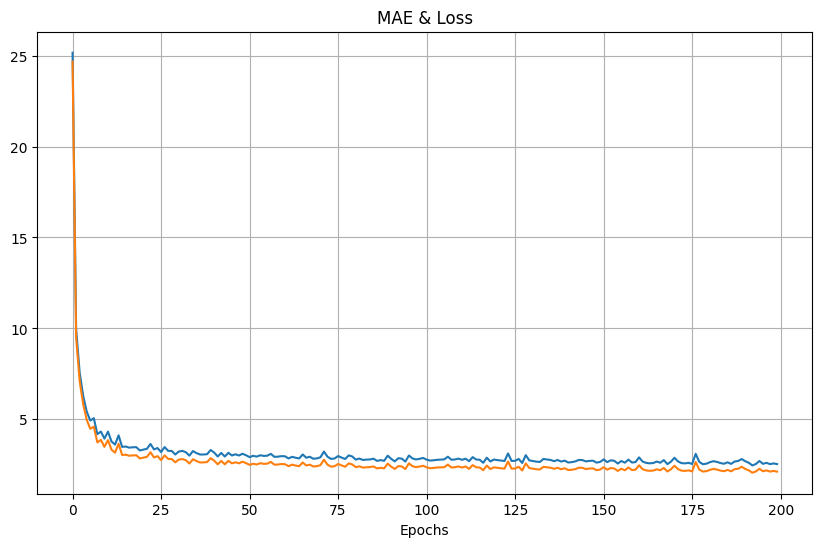

In [68]:
hist_mae = hist.history['mae']
hist_loss = hist.history['loss']

plot_series(range(len(hist_loss)), (hist_mae, hist_loss), title="MAE & Loss", xlabel="Epochs")

12/12 [==============================] - 2s 15ms/step


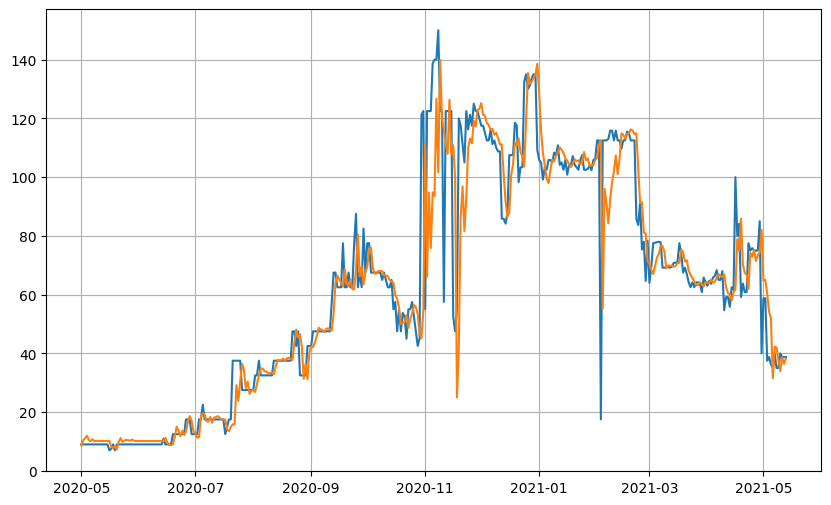

In [69]:
forecasts = model.predict(ds_test)

forecasts = forecasts.squeeze()  # remove the single axis

plot_series(time_test, (X_test, forecasts))

In [70]:
mae = mean_absolute_error(X_test, forecasts).numpy()
mean = np.mean(X_test)

print(f"MAE = {mae:.2f}")
print(f"MAE / mean = {(mae/mean * 100):.2f} %")

MAE = 7.21
MAE / mean = 11.40 %


In [71]:
forecasts1 = forecasts.flatten()
forecasts1.shape

(375,)

In [72]:
dff=df_test.reset_index()
dff

,Date,Average
0,2020-05-01,9.00
1,2020-05-02,9.00
2,2020-05-03,9.00
3,2020-05-04,9.00
4,2020-05-05,9.00
...,...,...
370,2021-05-09,35.00
371,2021-05-10,40.00
372,2021-05-11,38.75
373,2021-05-12,38.75


In [73]:
Index=dff.Date
Index

0     2020-05-01
1     2020-05-02
2     2020-05-03
3     2020-05-04
4     2020-05-05
         ...    
370   2021-05-09
371   2021-05-10
372   2021-05-11
373   2021-05-12
374   2021-05-13
Name: Date, Length: 375, dtype: datetime64[ns]

In [74]:
result = pd.DataFrame({
    'Date': Index,
    'price': forecasts1,
})
result

,Date,price
0,2020-05-01,8.632845
1,2020-05-02,10.431090
2,2020-05-03,11.054583
3,2020-05-04,11.946879
4,2020-05-05,10.551596
...,...,...
370,2021-05-09,37.621288
371,2021-05-10,33.942223
372,2021-05-11,38.647236
373,2021-05-12,36.421272


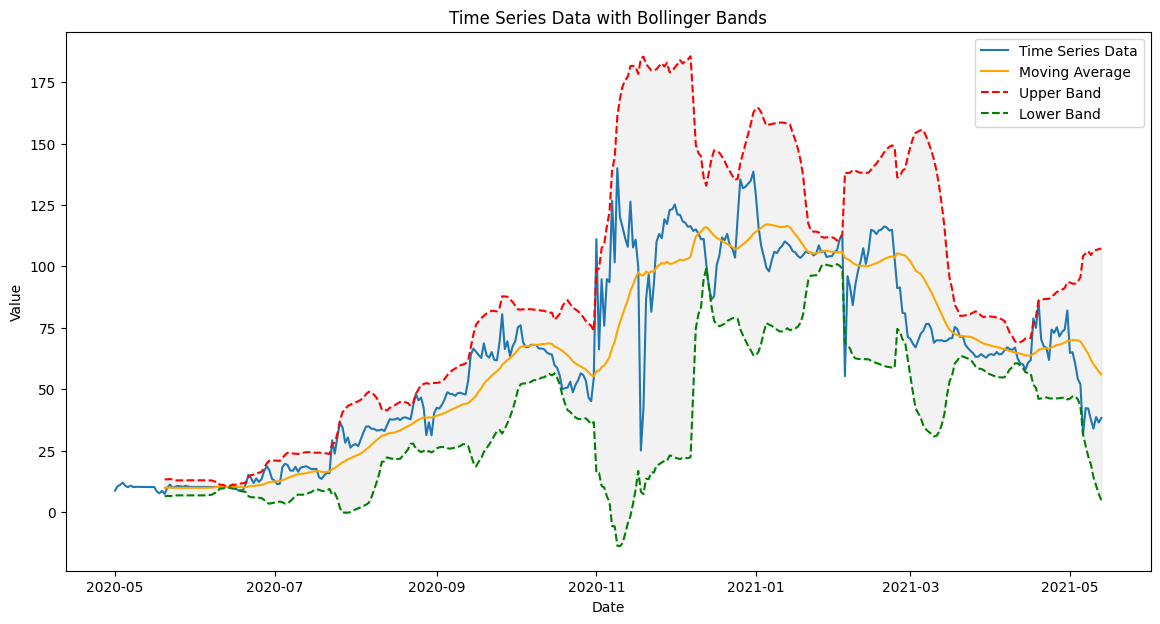

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sample data (replace with your own time series data)
# Assuming 'date' is your datetime column and 'average' is your data column
result1 = pd.DataFrame({
    'date': result.Date,
    'average': result.price  # Replace with your actual data
})

# Set the 'date' column as the index
result1.set_index('date', inplace=True)

# Ensure data is numeric
data = pd.to_numeric(result1['average'], errors='coerce')

# Define parameters
window = 20  # Number of periods for the moving average
num_std_dev = 3 # Number of standard deviations for the bands

# Calculate the moving average
moving_avg = data.rolling(window=window).mean()

# Calculate the rolling standard deviation
rolling_std = data.rolling(window=window).std()

# Calculate the Bollinger Bands
upper_band = moving_avg + (rolling_std * num_std_dev)
lower_band = moving_avg - (rolling_std * num_std_dev)

# Plot the data and Bollinger Bands
plt.figure(figsize=(14, 7))
plt.plot(result1.index, data, label='Time Series Data')
plt.plot(result1.index, moving_avg, label='Moving Average', color='orange')
plt.plot(result1.index, upper_band, label='Upper Band', color='red', linestyle='--')
plt.plot(result1.index, lower_band, label='Lower Band', color='green', linestyle='--')
plt.fill_between(result1.index, lower_band, upper_band, color='grey', alpha=0.1)
plt.legend()
plt.title('Time Series Data with Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [78]:
# Assuming you have a forecasted series named 'forecasted'
# Add forecasted data to the DataFrame

# Identify dates where forecasted values exceed the upper Bollinger Band
overshoot_dates = result1[result1['average'] > upper_band].index
undershoot_dates = result1[result1['average'] < lower_band].index

# Print the dates where the forecast is overshooting the upper Bollinger Band
print("Dates where the forecast is overshooting the upper Bollinger Band:")
print(overshoot_dates)
print("Dates where the forecast is undershooting the lower Bollinger Band:")
print(undershoot_dates)

Dates where the forecast is overshooting the upper Bollinger Band:
DatetimeIndex(['2020-06-15', '2020-06-21', '2020-07-23', '2020-08-24',
               '2020-11-01', '2021-04-17'],
              dtype='datetime64[ns]', name='date', freq=None)
Dates where the forecast is undershooting the lower Bollinger Band:
DatetimeIndex(['2020-06-17', '2020-12-14', '2021-02-04', '2021-05-06'], dtype='datetime64[ns]', name='date', freq=None)
